In [83]:
from functions import util as util
from functions import event_parser as EvtParser
from functions import hit_parser as HitParser

import h5py
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import yaml

In [84]:
switch_xz = False
# module0, 2x2, 2x2_MR4, ndlar, singlecube
detector = "singlecube"

In [85]:
f = h5py.File('/Users/emoore06/Work/research/sclarpix_analysis/data/sc_muonshower_larndsim.06.h5', 'r')
packets = f['packets'] # readout
segs = f['segments'] # Geant4 truth
assn = f['mc_packets_assn'] # G4-readout association
vtx = f['vertices']
traj = f['trajectories']

In [86]:
'''
    Loading LArPix geometry and run configuration
    Option 3: Build a LArPix geometry dictionary on the fly and load a run configuration yaml file
'''
from functions import geom_to_dict as DictBuilder
geom_repo = '/Users/emoore06/Work/research/sclarpix_analysis/config_repo'
larpix_layout_name = 'single_tile_layout-2.4.1'
geom_dict = DictBuilder.larpix_layout_to_dict(larpix_layout_name, geom_repo, save_dict=False)

run_config_path = '/Users/emoore06/Work/research/sclarpix_analysis/config_repo/singlecube.yaml'
run_config = util.get_run_config(run_config_path)

In [87]:
if switch_xz:
    tpc_centers_tp = np.array(run_config['tpc_offsets'])
    tpc_centers = np.copy(tpc_centers_tp)
    tpc_centers[:,0] = tpc_centers_tp[:,2]
    tpc_centers[:,2] = tpc_centers_tp[:,0]
else:
    tpc_centers = run_config['tpc_offsets']

In [88]:
pckt_event_ids = EvtParser.packet_to_eventid(assn, segs)
event_ids = EvtParser.get_eventid(vtx)
t0_grp = EvtParser.get_t0_event(vtx, run_config)

Found no 'beam_duration' in the configuration file


In [89]:
xyzdQevents = []
segevents = []
zvals = []
dQvals = []

for i_ev, evt_id in enumerate(event_ids):

    t0 = t0_grp[i_ev]
    evt_id = event_ids[i_ev]

    pckt_mask = pckt_event_ids == evt_id
    packets_ev = packets[pckt_mask]
    assn_ev = assn[pckt_mask]
    seg_ev = segs[segs['event_id'] == evt_id]
    
    x,y,z,dQ, v_drift_arr, t_drift_arr = HitParser.hit_parser_charge(t0, packets_ev, geom_dict, run_config, switch_xz)

    x = np.array(x) / 10. #Converting from mm to cm
    y = np.array(y) / 10. #Converting from mm to cm
    z = np.array(z) / 10. #Converting from mm to cm

    segevents.append(seg_ev)
    zvals.append(z)
    dQvals.append(dQ)
    xyzdQevents.append((x,y,z,dQ))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


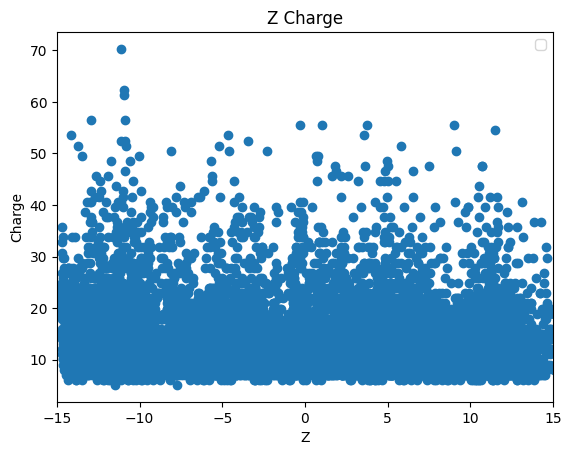

In [90]:
def flatten(xss):
    return [x for xs in xss for x in xs]

dQflat = flatten(dQvals)
zflat = flatten(zvals)

#Do histogram

fig = plt.figure()
plt.scatter(zflat, dQflat)
#plt.hist(dQflat)
plt.title("Z Charge")
plt.xlabel("Z")
plt.ylabel("Charge")
plt.xlim(-15, 15)
plt.legend()
plt.show()